# TP Final DH 2018


In [38]:
## These are some helper functions to plot the outputs of our models..

def plot_training_epochs(history):
    plt.figure(figsize=(15, 10))
    plt.plot(history.epoch, history.history['acc'])
    plt.plot(history.epoch, history.history['val_acc'])
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    l = plt.legend(['training accuracy', 'validation accuracy'])

def plot_images_with_label(images, labels, class_):
    img_to_plot = images[labels[:, class_]==1, ...]

    fig, axes = plt.subplots(1, 4, figsize=(15, 10))
    for ax, img in zip(axes, img_to_plot):
        ax.imshow(array_to_img(img))
        ax.axis('off')
        
def print_confusion_matrix(y_true, y_hat):
    return pd.DataFrame(confusion_matrix(y_true, y_hat),
                        index=['true_' + cls for cls in classes],
                        columns=['pred_' + cls for cls in classes])

def rand_by_mask(mask, n=4):
    return np.random.choice(np.where(mask)[0], n, replace=False)

def rand_by_correct(is_correct, y_true, y_hat, n=4):
    return rand_by_mask((y_true == y_hat) == is_correct, n=n)

def plot_image_ids(image_ids, generator):
    images = np.array(generator.filenames)[image_ids]
    print("True classes: %s" % ' '.join(img.split('/')[0] for img in images))
    fig, axes = plt.subplots(1, len(images), figsize=(15, 10))
    for ax, img in zip(axes, images):
        image = load_img(path_to_data + '/valid/' + img)
        ax.imshow(image)
        ax.axis('off')

def plot_correct_classifications(y_true, y_hat, valid_gen, n=4):
    image_ids = rand_by_correct(True, y_true, y_hat, n=n)
    print("Predictions: %s" % ' '.join(classes[i] for i in y_hat[image_ids]))
    plot_image_ids(image_ids, valid_gen)

def plot_incorrect_classifications(y_true, y_hat, valid_gen, n=4):
    image_ids = rand_by_correct(False, y_true, y_hat, n=n)
    print("Predictions: %s" % ' '.join(classes[i] for i in y_hat[image_ids]))
    plot_image_ids(image_ids, valid_gen)


## Loading data

In [39]:
path_to_data = './Data'

In [40]:
# Load some of the things we need from keras
from keras.preprocessing.image import ImageDataGenerator          # generator to cycle through images
from keras.preprocessing.image import array_to_img                # function to convert arrays back to images 
from keras.applications.imagenet_utils import preprocess_input    # normalization function for ImageNet
from keras.preprocessing.image import load_img                    # function to load image

import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline

UsageError: Line magic function `%` not found.


In [54]:
## Set up some global variables
# Batch size is how many images the network looks at at a time
batch_size = 16

# The image size is what we should scale the images to
image_size = (224, 224)

# This is the number of classes to classify.
n_classes = 2

In [5]:
!pip install requests
!pip install Pillow
!pip install tqdm

In [6]:
#!rm -Rf Data

In [ ]:
# !python3 ./download_archive.py --filter malignant --num-images 10
!python3 ./ISIC-Archive-Downloader-master/download_archive.py --filter benign --num-images 100 --images-dir ./Data/train/benign/images --descs-dir ./Data/train/benign/descriptions 
#--images-dir /data/isic/images --descs-dir /data/isic/descriptions
#!python3 ./download_archive.py --num-images 1000

In [ ]:
# 
#!python sort_isic_images.py

In [55]:
## Create data generators
# Create a generator that runs `preprocess_input` on every loaded image.
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

# Create the training and validation generators.
# They use the image sizes, batch sizes, and paths to data set above.
print('Load training.')
train_gen = data_generator.flow_from_directory(path_to_data + '/train',
                                               batch_size=batch_size,
                                               target_size=image_size)
print('\nLoad validation.')
valid_gen = data_generator.flow_from_directory(path_to_data + '/valid',
                                               batch_size=batch_size,
                                               target_size=image_size,
                                               shuffle=False)

# Create a list of classes sorted by index
classes = [cls[0] for cls in sorted(train_gen.class_indices.items(), key=lambda e: e[1])]

Load training.
Found 160 images belonging to 2 classes.

Load validation.
Found 160 images belonging to 2 classes.


The generators `train_gen` and `test_gen` will iterate over training and testing images. 

Each output will be a tuple of image-tensor and label-vector.

Try plotting the first image:

In [56]:
images, labels = next(train_gen)

In [45]:
images

array([[[[ 60.060997 ,  58.221    ,  81.32     ],
         [ 54.060997 ,  60.221    ,  86.32     ],
         [ 62.060997 ,  67.221    ,  91.32     ],
         ...,
         [ 67.061    ,  65.221    ,  86.32     ],
         [ 89.061    ,  83.221    , 101.32     ],
         [ 67.061    ,  73.221    ,  99.32     ]],

        [[ 53.060997 ,  57.221    ,  76.32     ],
         [ 60.060997 ,  63.221    ,  85.32     ],
         [ 67.061    ,  66.221    ,  87.32     ],
         ...,
         [ 88.061    ,  84.221    , 104.32     ],
         [ 86.061    ,  80.221    , 100.32     ],
         [ 70.061    ,  75.221    ,  97.32     ]],

        [[ 54.060997 ,  61.221    ,  79.32     ],
         [ 57.060997 ,  58.221    ,  79.32     ],
         [ 60.060997 ,  64.221    ,  78.32     ],
         ...,
         [ 92.061    ,  92.221    ,  99.32     ],
         [ 91.061    ,  85.221    , 103.32     ],
         [ 76.061    ,  78.221    ,  90.32     ]],

        ...,

        [[ 64.061    ,  65.221    ,  8

In [20]:
classes

['Benignas', 'Malignas']

Images here contains a tensor with shape:

`(batch_size, image_height, image_width, image_channels)`

In our case that is:

In [57]:
images.shape

(16, 224, 224, 3)

The output of labels is a one-hot encoding of the class

The dictionary of the class can be seen in:

In [47]:
train_gen.class_indices

{'Benignas': 0, 'Malignas': 1}

In [48]:
labels

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

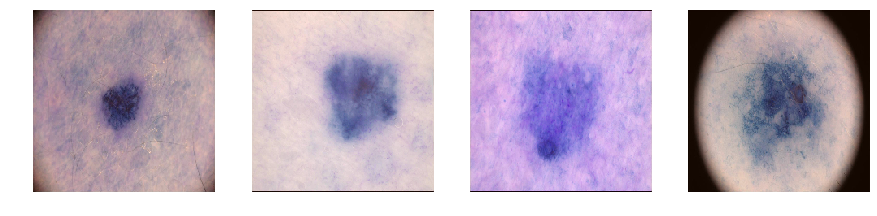

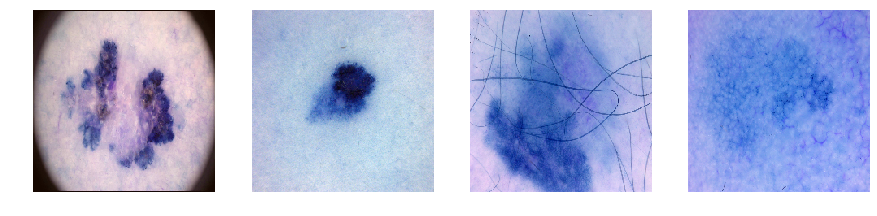

In [58]:
plot_images_with_label(images, labels, 0)
plot_images_with_label(images, labels, 1)

## Train a basic network

Keras has multiple predefined networks that work well for different tasks under `keras.applications`.

They are normally designed to perform on the 1000-class [ImageNet](https://www.image-net.org/) dataset.

In our case we only have benign / malignant (or cats vs. dogs), so we need to specify that we want the networks with two instead of a thousand outputs.

In [59]:
from keras.applications.resnet50 import ResNet50
from keras.optimizers import Adam

# Create the resnet model
model = ResNet50(classes=2, weights=None)

# Compile model - don't worry about this :)
model.compile('adam', loss='binary_crossentropy', metrics=['accuracy'])

The model we loaded here has `weights=None`, with this we will randomly initialize the weights of the model.

Keras models have methods for doing a bunch of the basic things we might want to do. 

The resnet model is very big:

In [53]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

To train the model you can run `model.fit_generator`

Every time the model has trained once on the training data it will evaluate it's accuracy on the validation data. The resulting training and validation accuracies are printed.

When you're done running this you can plot them. 

Try increasing the number of epochs to run - can you get it to train?

In [60]:
history = model.fit_generator(
    train_gen,
    validation_data=valid_gen,
    epochs=2,
    verbose=1
)

Epoch 1/2
 - 574s - loss: 3.6262 - acc: 0.5687 - val_loss: 7.9098 - val_acc: 0.5000
Epoch 2/2
 - 748s - loss: 1.6653 - acc: 0.6437 - val_loss: 7.9558 - val_acc: 0.4813


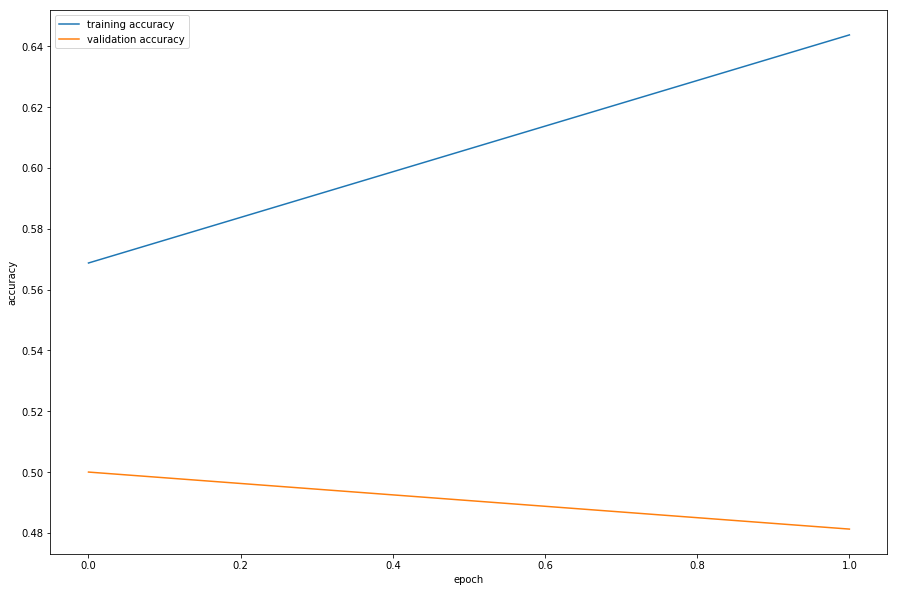

In [61]:
plot_training_epochs(history)

In [62]:
# Get some metrics for evaluating the notebook
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd

y_pred = model.predict_generator(valid_gen, verbose=1)
y_hat = np.argmax(y_pred, axis=1)
y_true = valid_gen.classes

10/10 [==============================] - 205s 20s/step


In [63]:
print('Accuracy: %0.4f' % accuracy_score(y_true, y_hat))
print('Confusion matrix:')
print_confusion_matrix(y_true, y_hat)

Accuracy: 0.4813
Confusion matrix:


,pred_Benignas,pred_Malignas
true_Benignas,76,4
true_Malignas,79,1


You can also plot random examples of correctly and incorrectly classified images using the cells below.

As they are randomized you can see more examples by rerunning the cells.

Is there a pattern to the incorrectly classified examples?

In [ ]:
plot_incorrect_classifications(y_true, y_hat, valid_gen, n=4)

In [ ]:
plot_correct_classifications(y_true, y_hat, valid_gen, n=4)

Even after a bunch of epochs, the model doesn't really get any better. This might be due to the relatively small data set we're using here.

## Transfer learning

In transfer learning we take a model that was initially trained on one task and use it for another task.

All models in `keras.applications` are pre-trained on the 1000 classes in ImageNet, with _a lot_ of data for each class. This means that they can learn the low level representations of objects, and we just need to 

In [ ]:
from keras.layers import Dense
from keras.models import Model
from keras.layers import BatchNormalization

# Load the ResNet model - now with pretrained imagenet weights
model_imagenet = ResNet50(weights='imagenet')

# Create an output layer with two classes instead of 1000. 
# The input to that layer should be the second to last layer of the imagenet model.
output_layer = Dense(n_classes, activation='softmax')(model_imagenet.layers[-2].output)

# Now we can build a new model with our self-defined activation output:
model = Model(inputs=model_imagenet.input, outputs=output_layer)

This new model will have all layers trainable. We only want to train the layer we added to the top of the model.

You can set a layer to be trainable like this:

In [ ]:
output_layer.trainable = True

If set to `False` it will be untrainable.

Set all layers in model to not train, except the output layer:

In [ ]:
for layer in model_imagenet.layers[:-1]:
    if isinstance(layer, BatchNormalization):
        continue
    layer.trainable = False

Now we can compile the model.

In [ ]:
# Compile model - don't worry about this :)
model.compile('adam', loss='binary_crossentropy', metrics=['accuracy'])

Now try fitting the generator as above.

In [ ]:
history = model.fit_generator(train_gen,
                              validation_data=valid_gen,
                              epochs=2,
                              )

In [ ]:
plot_training_epochs(history)

We can inspect results similar to above.

Are there any new learnings from the incorrect/correct examples?

Try training for longer - how does the train/valid accuracy change?

In [ ]:
y_pred = model.predict_generator(valid_gen, verbose=1)
y_hat = np.argmax(y_pred, axis=1)
y_true = valid_gen.classes

In [ ]:
print('Accuracy: %0.4f' % accuracy_score(y_true, y_hat))
print('Confusion matrix:')
print_confusion_matrix(y_true, y_hat)

In [ ]:
plot_incorrect_classifications(y_true, y_hat, valid_gen, n=4)

In [ ]:
plot_correct_classifications(y_true, y_hat, valid_gen, n=4)

## Data augmentation

We see a much better training accuracy then before, but we can also see a bit of overfitting. This is because - when training on the same data multiple times - the model will learn to just remember the data that was shown previously.

Since images are very dense with information it is quite easy for this big of a model to remember patterns in each of the images in our data set. To force the model to generalize we can use data augmentation.

Data augmentation adds a small random transformation to an image everytime it's loaded (once per epoch).

The augmentations we use here are flips, rotations, and zoom.

This sure that the model never sees the __exact__ same image twice.

Data augmentation is very easy to add in the `ImageDataGenerator` in keras:

In [ ]:
# Specify how much data augmentation we want on the images.
data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=40.0, # degrees of rotation
    zoom_range=0.3
)

train_gen = data_generator.flow_from_directory(path_to_data + '/train', batch_size=batch_size, target_size=image_size)
valid_gen = data_generator.flow_from_directory(path_to_data + '/valid',
                                               batch_size=batch_size,
                                               target_size=image_size,
                                               shuffle=False)

In [ ]:
imgs, labs = next(train_gen)
plt.imshow(array_to_img(imgs[0, ...]))

In [ ]:
history = model.fit_generator(train_gen,
                              validation_data=valid_gen,
                              epochs=15,
                              )

In [ ]:
plot_training_epochs(history)

In [ ]:
y_pred = model.predict_generator(valid_gen, verbose=1)
y_hat = np.argmax(y_pred, axis=1)
y_true = valid_gen.classes

In [ ]:
print('Accuracy: %0.4f' % accuracy_score(y_true, y_hat))
print('Confusion matrix:')
print_confusion_matrix(y_true, y_hat)

In [ ]:
plot_incorrect_classifications(y_true, y_hat, valid_gen, n=4)

In [ ]:
plot_correct_classifications(y_true, y_hat, valid_gen, n=4)